# Project part E - Refactored with ObjectTracker Class

Static object tracking through multiple frames using SAM and DINOv2.

## Dependencies and Imports

In [1]:
# Install dependencies
!pip install --upgrade pip
!pip install torch==2.4.0+cu121 torchvision==0.19.0+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.44.0 huggingface-hub==0.24.0 pillow numpy opencv-python open3d ipympl rerun-sdk[notebook]

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
# Import required libraries
import os
from typing import Dict, List, Optional
import cv2
import numpy as np
import matplotlib.cm as cm
from PIL import Image, ImageDraw
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import AutoImageProcessor, AutoModel
import requests

# Import lab utility functions
from lab_utils.data_utils import get_frame_list, load_camera_poses, validate_and_align_frame_data, load_camera_intrinsics
from lab_utils.tsdf_utils import build_tsdf_point_cloud
from lab_utils.model_loaders import load_sam_model, load_clip_model, load_dino_model, load_depthanything_pipeline

/home/jovyan/EmbodiedAIProject/project/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Configuration

In [3]:
class Config:
    # Scene Configuration
    SCENE_ID = "47333473"
    BASE_PATH = f"ARKitScenesData/{SCENE_ID}/{SCENE_ID}_frames"
    RGB_PATH = os.path.join(BASE_PATH, "lowres_wide")
    DEPTH_PATH = os.path.join(BASE_PATH, "lowres_depth")
    INTRINSICS_PATH = os.path.join(BASE_PATH, "lowres_wide_intrinsics")
    TRAJ_FILE_PATH = os.path.join(BASE_PATH, "lowres_wide.traj")
    
    # Project Configuration
    PROJECT_CONFIG = {
        'frame_skip': 7,                                  
        'max_frames': 40,                                  
        'grid_size': 6,                                    
        'sam_confidence_threshold': 0.5,                   
        'clip_model': 'openai/clip-vit-base-patch32',      
        'example_viz_index': 29,                          
        'padding_ratio_image_crops': 0.1                   
    }
    
    # Tracking Configuration (NEW)
    TRACKING_CONFIG = {
        'similarity_threshold': 0.6,      # Minimum score to consider a match
        'feature_weight': 0.8,            # Weight for feature similarity (alpha)
        'spatial_weight': 0.2,            # Weight for spatial similarity (1-alpha)
        'moving_target': False,           # Enable target updates
        'update_momentum': 0.1,           # How much to update target (0.1 = conservative)
        'confidence_threshold': 0.8,      # Minimum confidence for target update
        'use_depth': True,                # Use depth from RGB-D
    }
    
    # TSDF Configuration (for visualization)
    TSDF_CONFIG = {
        'frame_skip': 3,
        'depth_scale': 1000.0,
        'depth_trunc': 7.0,
        'voxel_size': 0.04,
        'batch_size': 20,
        'max_frames': 1000,
        'volume_length': 30.0,
        'resolution': 512,
    }
    
    # Rerun Viewer Dimensions
    RERUN_WIDTH, RERUN_HEIGHT = 1200, 700

# Create and validate config
config = Config()

## Core Classes

### Object Tracker Class

The `ObjectTracker` class encapsulates all the tracking logic in a clean interface. It handles:

- **Target Management**: Setting and updating the reference object features
- **Configuration**: Using the centralized tracking config for all parameters
- **Similarity Matching**: Combining DINOv2 features with 3D spatial information  
- **Moving Target Updates**: Optionally adapting to appearance changes over time

In [4]:
class ObjectTracker:
    """Lightweight object tracker for multi-frame tracking."""
    
    def __init__(self, config):
        self.config = config
        self.target_features = None
        self.target_bbox = None
        self.tracking_history = []  # Optional: for debugging/analysis
        
    def set_target(self, features, bbox_3d):
        """Set the initial target to track."""
        self.target_features = features.copy() if hasattr(features, 'copy') else np.array(features)
        self.target_bbox = bbox_3d.copy() if hasattr(bbox_3d, 'copy') else np.array(bbox_3d)
        
    def find_best_match(self, objects):
        """Find the best matching object in the current frame."""
        if self.target_features is None:
            return None
            
        if not objects:
            return None
            
        best_idx = None
        best_score = 0.0
        best_sim_features = 0.0  
        best_sim_spatial = 0.0
        similarity_threshold = self.config.TRACKING_CONFIG['similarity_threshold']
        alpha = self.config.TRACKING_CONFIG['feature_weight']

        for i, obj in enumerate(objects):
            features = obj['features']
            bbox_3d = obj['bbox_3d']
            centroid = obj['centroid']
            
            # Hard distance cutoff 
            target_centroid = (self.target_bbox[0] + self.target_bbox[1]) / 2.0
            distance = np.linalg.norm(centroid - target_centroid)
            if distance > 0.5:  # Hard threshold
                continue
            
            # Feature similarity (cosine similarity)
            sim_features = np.dot(self.target_features, features) / (
                np.linalg.norm(self.target_features) * np.linalg.norm(features) + 1e-8
            )
            
            # Spatial similarity (3D IoU)
            sim_spatial = self._bbox3d_iou(self.target_bbox, bbox_3d)

            # Combined score
            score = alpha * sim_features + (1 - alpha) * sim_spatial
            
            if score > best_score and score >= similarity_threshold:
                best_score = score
                best_idx = i
                best_sim_features = sim_features  
                best_sim_spatial = sim_spatial   
                
        if best_idx is not None:
            match_result = {
                'index': best_idx, 
                'score': best_score,
                'feature_sim': best_sim_features,
                'spatial_sim': best_sim_spatial
            }
            self.tracking_history.append(match_result)
            return match_result
            
        return None
    
    def update_target(self, new_features, new_bbox, confidence_score):
        """Update target with new features (moving target)."""
        if not self.config.TRACKING_CONFIG['moving_target']:
            return  # Moving target disabled
            
        confidence_threshold = self.config.TRACKING_CONFIG['confidence_threshold']
        if confidence_score < confidence_threshold:
            return  # Not confident enough to update
            
        momentum = self.config.TRACKING_CONFIG['update_momentum']
        
        # Weighted update - keeps some "memory" of original target
        self.target_features = (1 - momentum) * self.target_features + momentum * new_features
        self.target_bbox = (1 - momentum) * self.target_bbox + momentum * new_bbox
        

    
    def _bbox3d_iou(self, b1, b2):
        """Calculate 3D IoU between two bounding boxes."""
        b1_min, b1_max = b1[0], b1[1]
        b2_min, b2_max = b2[0], b2[1]

        x_min = max(b1_min[0], b2_min[0])
        y_min = max(b1_min[1], b2_min[1])
        z_min = max(b1_min[2], b2_min[2])
        x_max = min(b1_max[0], b2_max[0])
        y_max = min(b1_max[1], b2_max[1])
        z_max = min(b1_max[2], b2_max[2])
        
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            return 0.0

        inter_vol = (x_max - x_min) * (y_max - y_min) * (z_max - z_min)
        vol1 = (b1_max - b1_min).prod()
        vol2 = (b2_max - b2_min).prod()
        
        return inter_vol / (vol1 + vol2 - inter_vol + 1e-8)

## Feature Extraction Functions

### SAM Proposals

We filter proposals by confidence threshold and remove duplicates to get clean object candidates.

Here we use SAM (Segment Anything Model) with a grid of point prompts, same approach as in Lab2 to generate object proposals.

Each proposal contains:
- **point**: Grid point that generated this proposal
- **confidence**: SAM's confidence score for this segmentation
- **mask**: Binary segmentation mask for the object
- **area**: Number of pixels in the mask (for filtering small objects)

In [5]:
def generate_sam_proposals_project(image: Image.Image,
                          sam_model,
                          sam_processor,
                          device: str,
                          grid_size: int = 6,
                          confidence_threshold: float = 0.5) -> List[Dict]:
    """Generate object proposals using SAM with a grid of point prompts."""
    width, height = image.size
    # Generate grid of point prompts
    x_points = np.linspace(width * 0.1, width * 0.9, grid_size)
    y_points = np.linspace(height * 0.1, height * 0.9, grid_size)
    
    proposals = []
    processed_masks = []
    
    tqdm.write(f"Generating SAM proposals with {grid_size}x{grid_size} grid...")
    
    for i, x in enumerate(x_points):
        for j, y in enumerate(y_points):
            input_points = [[[x, y]]]
            
            try:
                inputs = sam_processor(
                    images=image,
                    input_points=input_points,
                    return_tensors="pt"
                )
                
                inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                         for k, v in inputs.items()}
                
                with torch.no_grad():
                    outputs = sam_model(**inputs)
                
                masks = sam_processor.image_processor.post_process_masks(
                    outputs.pred_masks.cpu(),
                    inputs["original_sizes"].cpu(),
                    inputs["reshaped_input_sizes"].cpu()
                )
                
                batch_masks = masks[0]
                if len(batch_masks) == 0:
                    continue
                
                point_masks = batch_masks[0]
                if len(point_masks) == 0:
                    continue
                
                best_mask_idx = 0  # Default to first mask
                best_score = 0.5   # Default confidence
                
                if hasattr(outputs, 'iou_scores') and outputs.iou_scores is not None:
                    try:
                        iou_scores = outputs.iou_scores[0,0,:].cpu().numpy()
                        if len(iou_scores) > 0:
                            best_mask_idx = int(np.argmax(iou_scores))
                            best_score = float(iou_scores[best_mask_idx])
                             
                            if best_score < confidence_threshold:
                                continue
                    except:
                        pass
                
                mask = point_masks[best_mask_idx]
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().astype(bool)
                else:
                    mask_np = np.array(mask).astype(bool)
                
                # Check for duplicates
                is_duplicate = False
                for existing_mask in processed_masks:
                    overlap = np.sum(mask_np & existing_mask)
                    union = np.sum(mask_np | existing_mask)
                    if union > 0 and overlap / union > 0.8:
                        is_duplicate = True
                        break
                
                if not is_duplicate and np.sum(mask_np) > 100:
                    proposals.append({
                        'mask': mask_np,
                        'area': np.sum(mask_np),
                        'point': [x, y],
                        'confidence': best_score
                    })
                    processed_masks.append(mask_np)
                    
            except Exception as e:
                continue
    
    tqdm.write(f"Generated {len(proposals)} unique segment proposals")
    return proposals

### CLIP Features

These features are used for initial target selection when a text query is provided.

We extract CLIP features from segmented regions to enable text-based object queries (like "ball" or "sofa").

The process:
1. **Make bounding box** of the mask
2. **Crop the image** to the bounding box
3. **Expand with padding** to include context around the object

In [6]:
def extract_clip_features_from_segment(image: Image.Image,
                                  mask: np.ndarray,
                                  clip_model,
                                  clip_processor,
                                  device: str,
                                  padding_ratio: float = 0.1) -> Optional[np.ndarray]:
    """Extract CLIP features from a segmented region."""
    try:
        # Find bounding box of mask
        coords = np.where(mask)
        if len(coords[0]) == 0:
            return None
        
        y_min, y_max = coords[0].min(), coords[0].max()
        x_min, x_max = coords[1].min(), coords[1].max()
        
        # Expand bounds with padding
        pad_y = int((y_max - y_min) * padding_ratio)
        pad_x = int((x_max - x_min) * padding_ratio)

        y_min_exp = max(int(y_min - pad_y), 0)
        y_max_exp = min(int(y_max + pad_y), mask.shape[0])
        x_min_exp = max(int(x_min - pad_x), 0)
        x_max_exp = min(int(x_max + pad_x), mask.shape[1])

        image_crop = image.crop((int(x_min_exp), int(y_min_exp), int(x_max_exp), int(y_max_exp)))
                
        # Process with CLIP
        inputs = clip_processor(images=image_crop, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
            
            # Normalize image features
            image_features = image_features/ image_features.norm(p=2, dim=-1, keepdim=True)
        
        return image_features.cpu().numpy().squeeze()
        
    except Exception as e:
        print(f"Failed to extract CLIP features: {e}")
        return None

### DINOv2 Features


DINOv2 provides superior visual features for object tracking compared to CLIP, especially for appearance-based matching across frames.

In [7]:
def extract_dino_features_from_segment(
    image: Image.Image,
    mask: np.ndarray,
    dino_model,
    dino_processor,
    device: str,
    padding_ratio: float = 0.1
) -> Optional[np.ndarray]:
    """Extract DINOv2 features from a segmented region."""
    try:
        # Find bounding box of mask
        coords = np.where(mask)
        if len(coords[0]) == 0:
            return None
        
        y_min, y_max = coords[0].min(), coords[0].max()
        x_min, x_max = coords[1].min(), coords[1].max()
        
        # Expand bounds with padding
        pad_y = int((y_max - y_min) * padding_ratio)
        pad_x = int((x_max - x_min) * padding_ratio)

        y_min_exp = max(int(y_min - pad_y), 0)
        y_max_exp = min(int(y_max + pad_y), mask.shape[0])
        x_min_exp = max(int(x_min - pad_x), 0)
        x_max_exp = min(int(x_max + pad_x), mask.shape[1])

        image_crop = image.crop((x_min_exp, y_min_exp, x_max_exp, y_max_exp))
        
        # Process with DINOv2
        inputs = dino_processor(images=image_crop, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = dino_model(**inputs)
            # Use the [CLS] token embedding or pooled output as image feature
            if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
                image_features = outputs.pooler_output
            else:
                image_features = outputs.last_hidden_state[:, 0]  # CLS token
            
            # Normalize features
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        
        return image_features.cpu().numpy().squeeze()
    
    except Exception as e:
        print(f"Failed to extract DINO features: {e}")
        return None

## 3D Position Extraction

To enable spatial tracking in world coordinates, we convert 2D segmentation masks into 3D object representations using camera geometry and depth data.

#### **What We Extract:**
- **Object position**: 3D centroid in world coordinates  
- **Object extent**: Axis-aligned bounding box for size/shape information
- **Spatial context**: Used for 3D IoU calculations in tracking similarity

#### **The Pipeline:**

**1. Pixel Sampling**
- **Sample up to 500 pixels** from the mask for computational efficiency
- **Filter minimum size**: Skip masks with fewer than 20 pixels (noise rejection)

**2. Depth Processing** 
- **Extract depth values** at sampled pixel locations
- **Filter valid depths**: Remove pixels with depth ≤ 0 (invalid/missing data)

**3. 3D Reconstruction**
- **Back-project to camera space**: Use intrinsics (fx, fy, cx, cy) to convert pixels → 3D points
- **Transform to world space**: Apply camera pose matrix for global coordinates

**4. Compact Representation**
- **Centroid**: Mean position of all valid 3D points
- **Bounding box**: [min_xyz, max_xyz] extent for spatial similarity

#### **Why This Approach:**
- **Efficient**: Sampling limits computation while preserving shape information
- **Robust**: Filters invalid depth data that could corrupt 3D positions  
- **Tracking-ready**: Compact format perfect for 3D IoU calculations between frames

In [8]:
def extract_3d_position_from_mask(
    mask: np.ndarray,
    depth_image: np.ndarray,
    camera_intrinsics: np.ndarray,
    camera_pose: np.ndarray,
    depth_scale: float,
    max_points: int = 500
) -> dict:
    """
    Convert a binary mask into compact 3D object representation:
    centroid + bounding box in world coordinates.

    Args:
        mask: Binary segmentation mask (H,W)
        depth_image: Depth map aligned with RGB (H,W), uint16 or float
        camera_intrinsics
        camera_pose
        depth_scale: scale factor for depth values
        max_points: number of pixels to sample from mask

    Returns:
        dict with 'centroid' and 'bbox_3d', or None if invalid
    """
    coords = np.column_stack(np.where(mask))  # (y, x) pixel indices
    if coords.shape[0] < 20:
        return None

    # Sample pixels if mask too large
    sample_idx = np.random.choice(len(coords), min(max_points, len(coords)), replace=False)
    coords = coords[sample_idx]

    # Depth values
    z = depth_image[coords[:, 0], coords[:, 1]].astype(np.float32) / depth_scale
    valid = z > 0
    if not np.any(valid):
        return None

    coords = coords[valid]
    z = z[valid]

    # Get camera parameters
    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]
    
    x = (coords[:, 1] - cx) * z / fx
    y = (coords[:, 0] - cy) * z / fy
    pts_cam = np.stack([x, y, z], axis=-1)

    # Camera → World
    pts_h = np.concatenate([pts_cam, np.ones((pts_cam.shape[0], 1))], axis=-1).T
    pts_world = (camera_pose @ pts_h)[:3].T

    # Compact representation
    centroid = pts_world.mean(axis=0)
    bbox_min = pts_world.min(axis=0)
    bbox_max = pts_world.max(axis=0)

    return {
        'centroid': centroid,
        'bbox_3d': np.stack([bbox_min, bbox_max])
    }

## Frame Processing

Each processed frame contains a list of detected objects with their visual features, spatial location, and metadata.

This is where we put it all together for each frame:

1. **Load RGB and depth images** for the frame

2. **Generate SAM proposals** using the grid-based approach
3. **Extract features** for each proposal (both DINOv2 and CLIP)
4. **Calculate 3D positions** from masks and depth data
5. **Package results** into a structured format for tracking

In [9]:
def process_frame_project(frame_data: Dict,
        sam_model, sam_processor,
        dino_model, dino_processor,
        clip_model, clip_processor,
        device: str,
        config: Config,
        grid_size: int = 6) -> Dict:
    """Process a single frame for Project: SAM proposals + CLIP embeddings + DINOv2 features."""
    results = {
        'frame_name': frame_data['frame_name'],
        'objects': []
    }
    try:
        # Load images
        image = Image.open(frame_data['rgb_path']).convert("RGB")
        rgb_image = np.array(image)

        # Choose depth images
        if config.TRACKING_CONFIG["use_depth"]:
            depth_image = cv2.imread(frame_data['depth_path'], cv2.IMREAD_UNCHANGED)
        else:
            # Use an apporximation of the depth (DepthAnything)
            print("Using DepthAnything for depth estimation.")
            depth_map = pipe(image)["depth"] 
            depth_image = np.array(depth_map)
        
        # Generate SAM proposals
        proposals = generate_sam_proposals_project(
            image,
            sam_model,
            sam_processor,
            device,
            grid_size=grid_size,
            confidence_threshold=config.PROJECT_CONFIG['sam_confidence_threshold']
        )
        
        # Process each proposal
        for proposal in proposals:
            mask = proposal['mask']
            
            # Extract DINOv2 features
            dino_features = extract_dino_features_from_segment(
                image,
                mask,
                dino_model,
                dino_processor,
                device,
                padding_ratio=config.PROJECT_CONFIG['padding_ratio_image_crops'] 
            )
            
            if dino_features is None:
                continue

            clip_features = extract_clip_features_from_segment(
                image, mask, clip_model, clip_processor, device,
                padding_ratio=config.PROJECT_CONFIG['padding_ratio_image_crops']
            )
            
            # Get compact 3D position (Bounding 3D box + Centroid)
            pos_data = extract_3d_position_from_mask(
                mask,
                depth_image,
                frame_data['camera_intrinsics'],
                frame_data['camera_pose'],
                config.TSDF_CONFIG['depth_scale']
            )
            if pos_data is None:
                continue
            
            results['objects'].append({
                'features': dino_features,
                'clip_features': clip_features,
                'centroid': pos_data['centroid'],
                'bbox_3d': pos_data['bbox_3d'],
                'area_px': proposal['area'],
                'confidence': proposal['confidence']
            })
            
    except Exception as e:
        print(f"Error processing frame {frame_data['frame_name']}: {e}")

    return results

## Utility Functions

In [10]:
# Load camera poses
camera_poses = load_camera_poses(config.TRAJ_FILE_PATH)

def get_frame_list(config, frame_skip=1, max_frames=25, start_frame_name=None):
    files = sorted(os.listdir(config.RGB_PATH))
    frames = []

    # If start_frame_name is provided, find its index
    if start_frame_name is not None:
        try:
            start_idx = next(i for i, f in enumerate(files) if f == start_frame_name)
            files = files[start_idx:]  # start from that frame
        except StopIteration:
            raise ValueError(f"Start frame {start_frame_name} not found in {config.RGB_PATH}")

    for i, f in enumerate(files[::frame_skip]):
        if i >= max_frames:
            break

        timestamp = os.path.splitext(f)[0]

        # Load intrinsics for this frame
        try:
            K, image_size = load_camera_intrinsics(config.INTRINSICS_PATH, f)
        except Exception as e:
            print(f"Skipping {f}, failed to load intrinsics: {e}")
            continue

        # Load camera pose
        pose = camera_poses.get(timestamp, np.eye(4))

        frames.append({
            "frame_name": f,
            "timestamp": timestamp,
            "rgb_path": os.path.join(config.RGB_PATH, f),
            "depth_path": os.path.join(config.DEPTH_PATH, f.replace(".jpg", ".png")),
            "camera_intrinsics": K,
            "intrinsics_size": image_size,
            "camera_pose": pose
        })

    return frames

def project_points(K, points_3d):
    """Project 3D points to 2D for visualization."""
    uv_coords = []
    for X, Y, Z in points_3d:
        if Z > 0:
            uv = K @ np.array([X, Y, Z])
            u, v = uv[0] / uv[2], uv[1] / uv[2]
            uv_coords.append((u, v))
    return uv_coords

Loaded 540 camera poses


## High-Level Interface Functions

### Frame Analysis

The `analyse_frames()` function processes a sequence of frames to extract objects and their features for tracking.

#### **Configuration:**
- **n_frames**: Number of frames to process (default: 30)
- **start_frame**: Starting frame filename (e.g., "47333473_58534.757.png")
- **frame_skip**: Uses config setting to skip frames for efficiency

#### **Processing Pipeline:**
1. **Load models once** - SAM, DINOv2, and CLIP models loaded efficiently at startup
2. **Get frame metadata** - Camera poses, intrinsics, and file paths for each frame
3. **Process each frame** - Run the complete pipeline:
   - Generate SAM object proposals
   - Extract DINOv2 features for tracking
   - Extract CLIP features for text queries
   - Calculate 3D positions from depth data
4. **Package results** - Structured data ready for the ObjectTracker

#### **Output:**
- **frame_results**: List of frames, each containing detected objects with features and 3D positions
- **device**: GPU device handle for subsequent tracking operations

#### **Why This Approach:**
- **Model reuse**: Load expensive models once, not per frame
- **Structured output**: Consistent format for all tracking functions
- **Flexible sequences**: Start from any frame, process any number of frames

In [11]:
def analyse_frames(config, n_frames=30, start_frame="47333473_58549.751.png"):
    """
    Extract objects from multiple frames using SAM + DINO + CLIP.
    """
    # Load models
    sam_model, sam_processor, device = load_sam_model(model_size='base')
    dino_model, dino_processor, _ = load_dino_model(device=device)
    clip_model, clip_processor, _ = load_clip_model(device=device)

    # Get frame metadata
    frames_metadata = get_frame_list(config, frame_skip=1, max_frames=n_frames, start_frame_name=start_frame)

    all_results = []
    for frame_data in tqdm(frames_metadata, desc="Processing frames"):
        results = process_frame_project(
            frame_data,
            sam_model, sam_processor,
            dino_model, dino_processor,
            clip_model, clip_processor,
            device,
            config
        )
        results["frame_data"] = frame_data
        all_results.append(results)

    return all_results, device

### Tracking with Slider (Refactored)

**Interactive Visualization**: The `query_with_slider()` function implements the complete tracking pipeline with an interactive slider for visual assessment. Your eyes are the ground truth here!

#### **How It Works:**

**1. Target Selection**
- **With text query**: Uses CLIP similarity to find best matching object (e.g., "ball", "sofa")
- **Without query**: Selects largest object (most pixels) for better tracking stability

**2. Tracking Process**
- **Initialize tracker** with target features and 3D bounding box from selected object
- **For each frame**: Find best match using combined DINOv2 feature + 3D spatial similarity
- **Update target** (if moving_target enabled) using exponential moving average for adaptation

**3. Visualization**
- **Bounding boxes** are projected from 3D world coordinates to 2D image space
- **Interactive slider** lets you browse through frames to visually assess tracking quality
- **Red rectangles** show the tracked object's projected 3D bounding box

#### **Why This Approach:**
- **Visual assessment** is more reliable than automated metrics without ground truth
- **Interactive exploration** lets you see exactly when tracking succeeds or fails
- **3D-to-2D projection** provides spatial context from the world coordinate system

In [12]:
def query_with_slider(frame_results, device=None, query=None):
    """Track objects through frames with interactive slider - now using ObjectTracker class."""
    
    if not frame_results:
        print("Error: No frame results provided")
        return
    
    if not any(len(r['objects']) > 0 for r in frame_results):
        print("Error: No objects found in any frame")
        return

    if device is None:
        _, _, device = load_sam_model(model_size='base')

    clip_model, clip_processor, _ = load_clip_model(device=device)
    
    # Initialize tracker
    tracker = ObjectTracker(config)

    # Target selection logic
    text_features_np = None
    if query is not None:
        text_inputs = clip_processor(text=[query], return_tensors="pt").to(device)
        with torch.no_grad():
            text_features = clip_model.get_text_features(**text_inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        text_features_np = text_features.cpu().numpy().squeeze()

    # Pick object to track
    if query is None or text_features_np is None:            
        # Pick an object (first object with largest area for better tracking)
        best_object_id, best_frame_id = 0, 0
        best_area = 0
        
        # Look for substantial object in first few frames
        for f_idx in range(min(3, len(frame_results))):
            for o_idx, obj in enumerate(frame_results[f_idx]['objects']):
                if obj['area_px'] > best_area:
                    best_area = obj['area_px']
                    best_frame_id, best_object_id = f_idx, o_idx
        
    else:
        # Pick object by CLIP similarity with query
        best_score_overall = -1
        best_frame_id, best_object_id = None, None
        for f_idx, results in enumerate(frame_results):
            for o_idx, obj in enumerate(results['objects']):
                if obj['clip_features'] is None:
                    continue
                sim = float(np.dot(obj['clip_features'], text_features_np))
                if sim > best_score_overall:
                    best_score_overall = sim
                    best_frame_id, best_object_id = f_idx, o_idx

        if best_score_overall < 0:
            print("No suitable object found for query.")
            return

    # Set initial target
    target_features = frame_results[best_frame_id]['objects'][best_object_id]['features']
    target_bbox = frame_results[best_frame_id]['objects'][best_object_id]['bbox_3d']
    tracker.set_target(target_features, target_bbox)
    
    print(f"Starting tracking from frame {best_frame_id}, object {best_object_id}")
    print(f"Tracking config: moving_target={config.TRACKING_CONFIG['moving_target']}, threshold={config.TRACKING_CONFIG['similarity_threshold']}")

    # Process frames with tracker
    processed_frames = []
    print(f"Processing frames ...")
    
    for idx, results in enumerate(frame_results):
        frame = Image.open(results['frame_data']['rgb_path']).convert("RGB")
        overlay = frame.convert('RGBA')
        draw = ImageDraw.Draw(overlay, 'RGBA')

        if results['objects']:
            # Use tracker to find best match
            match = tracker.find_best_match(results['objects'])
            if match:
                best_idx = match['index']
                obj = results['objects'][best_idx]
                
                # Draw bounding box
                points_2d = project_points(results['frame_data']['camera_intrinsics'], obj['bbox_3d'])
                if points_2d:
                    xs, ys = zip(*points_2d)
                    x0, x1 = int(min(xs)), int(max(xs))
                    y0, y1 = int(min(ys)), int(max(ys))
                    draw.rectangle([x0, y0, x1, y1], outline=(255,0,0,180), width=3)
                
                # Update target if moving target is enabled
                tracker.update_target(obj['features'], obj['bbox_3d'], match['score'])

        processed_frames.append(overlay)

    # Create slider widget
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(processed_frames)-1,
        step=1,
        description='Frame'
    )
    out = widgets.Output()

    def show_frame(change):
        idx = change['new']
        with out:
            clear_output(wait=True)
            display(processed_frames[idx])

    slider.observe(show_frame, names='value')
    display(widgets.VBox([slider, out]))
    
    # Show first frame by default
    with out:
        display(processed_frames[0])
    
    return tracker

## Examples and Demonstrations

### Example 1: Track with Fixed Target (Default)

**Trade-off**: May lose track if the object's appearance changes significantly, but won't accidentally switch to tracking a different object.

This demonstrates the basic tracking approach where the target features **never change** after initialization.

**Use case**: When you want the most stable tracking that won't drift to other objects, even if the appearance changes due to lighting or viewpoint.

In [13]:
# Extract objects from frames
frame_results, device_id = analyse_frames(config, n_frames=20, start_frame="47333473_58548.751.png")

Loading SAM model (base)...


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

SAM model loaded on device: cuda
Loading DINOv2 model: facebook/dinov2-base...


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

DINOv2 model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/home/jovyan/EmbodiedAIProject/project/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP model loaded on device: cuda


Processing frames:   0%|          | 0/20 [00:00<?, ?it/s]

Generating SAM proposals with 6x6 grid...
Generated 12 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 9 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 9 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 11 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 11 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 12 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 14 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 12 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 11 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 11 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 13 unique segment proposals
Generating SAM proposals with 6x6 grid...
G

In [14]:
# Track with query (fixed target)
print("=== Tracking with Fixed Target ===")
tracker_fixed = query_with_slider(frame_results, device=None, query="pillow")

=== Tracking with Fixed Target ===
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Starting tracking from frame 5, object 4
Tracking config: moving_target=False, threshold=0.6
Processing frames ...


### Example 2: Track with Moving Average Target

**Trade-off**: Better handles appearance changes, but small risk of gradually drifting to a different object.

Here we enable adaptive tracking where the target features **gradually update** based on successful matches.

**Use case**: When lighting, shadows, or viewing angles change significantly across frames. The tracker adapts while maintaining object identity.

**Key parameters:**

- `moving_target = True`: Enable feature updates
- `confidence_threshold = 0.8`: Only update when very confident
- `update_momentum = 0.1`: Conservative update (10% new, 90% existing)

In [15]:
# Enable moving target
config.TRACKING_CONFIG['moving_target'] = True
config.TRACKING_CONFIG['update_momentum'] = 0.1  # Conservative update
config.TRACKING_CONFIG['confidence_threshold'] = 0.8

print("=== Tracking with Moving Target ===")
tracker_moving = query_with_slider(frame_results, device=None, query="pillow")

=== Tracking with Moving Target ===
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Starting tracking from frame 5, object 4
Tracking config: moving_target=True, threshold=0.6
Processing frames ...


### Example 3: Compare Tracking Settings

**Compare by**: Using the sliders to see when each approach loses/maintains tracking. Look for tracking gaps, bounding box jumps, or switches to wrong objects.

This example shows how different similarity thresholds affect tracking behavior. Each threshold gets its own interactive slider for direct comparison.
**Similarity Thresholds:**-
- **0.8 (Strict)**: Only high-confidence matches → fewer false positives but may lose track more easily
- **0.6 (Balanced)**: Moderate threshold → good balance of continuity and accuracy  
- **0.4 (Permissive)**: Accepts lower-confidence matches → more continuous tracking but higher false positive risk

In [16]:
# Reset to fixed target for comparison
config.TRACKING_CONFIG['moving_target'] = False

# Try different similarity thresholds with separate sliders
print("=== Comparing Different Similarity Thresholds ===")

original_threshold = config.TRACKING_CONFIG['similarity_threshold']

# Threshold 0.4 - Permissive
config.TRACKING_CONFIG['similarity_threshold'] = 0.4
print("\n--- Threshold 0.4 (Permissive) ---")
tracker_04 = query_with_slider(frame_results, device=None, query="bookshelf")

# Threshold 0.6 - Balanced  
config.TRACKING_CONFIG['similarity_threshold'] = 0.6
print("\n--- Threshold 0.6 (Balanced) ---")
tracker_06 = query_with_slider(frame_results, device=None, query="bookshelf")

config.TRACKING_CONFIG['similarity_threshold'] = original_threshold

# Threshold 0.8 - Strict# Reset to original

config.TRACKING_CONFIG['similarity_threshold'] = 0.8

print("\n--- Threshold 0.8 (Strict) ---")
tracker_08 = query_with_slider(frame_results, device=None, query="bookshelf")

=== Comparing Different Similarity Thresholds ===

--- Threshold 0.4 (Permissive) ---
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Starting tracking from frame 16, object 6
Tracking config: moving_target=False, threshold=0.4
Processing frames ...



--- Threshold 0.6 (Balanced) ---
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Starting tracking from frame 16, object 6
Tracking config: moving_target=False, threshold=0.6
Processing frames ...



--- Threshold 0.8 (Strict) ---
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Starting tracking from frame 16, object 6
Tracking config: moving_target=False, threshold=0.8
Processing frames ...


### Example 4: Track without Query (Largest Object)

**Use case**: Exploratory analysis when you don't know what objects are present or want to track the most prominent object in the scene.

When no text query is provided, the tracker automatically selects the largest detected object (by pixel area) as the target.


**Why largest object?**- 
- **Less noise**: Larger masks are less likely to be false detections
- **More stable tracking**: Larger objects have more feature information
- **Better for furniture**: In indoor scenes, large objects like sofas/tables are good tracking targets


In [17]:
# Track without specific query - will pick largest object
print("=== Tracking Largest Object (No Query) ===")
tracker_no_query = query_with_slider(frame_results, device=None, query=None)

=== Tracking Largest Object (No Query) ===
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Starting tracking from frame 1, object 3
Tracking config: moving_target=False, threshold=0.8
Processing frames ...


## Configuration Toggle Examples

In [18]:
# Show current configuration
print("Current Tracking Configuration:")
for key, value in config.TRACKING_CONFIG.items():
    print(f"  {key}: {value}")

print("\nTo modify tracking behavior:")
print("  config.TRACKING_CONFIG['moving_target'] = True/False")
print("  config.TRACKING_CONFIG['similarity_threshold'] = 0.4-0.9")
print("  config.TRACKING_CONFIG['feature_weight'] = 0.5-0.9 (vs spatial weight)")
print("  config.TRACKING_CONFIG['update_momentum'] = 0.05-0.3 (if moving_target=True)")

Current Tracking Configuration:
  similarity_threshold: 0.8
  feature_weight: 0.8
  spatial_weight: 0.2
  moving_target: False
  update_momentum: 0.1
  confidence_threshold: 0.8
  use_depth: True

To modify tracking behavior:
  config.TRACKING_CONFIG['moving_target'] = True/False
  config.TRACKING_CONFIG['similarity_threshold'] = 0.4-0.9
  config.TRACKING_CONFIG['feature_weight'] = 0.5-0.9 (vs spatial weight)
  config.TRACKING_CONFIG['update_momentum'] = 0.05-0.3 (if moving_target=True)


# Project part C - RGB-D vs DepthAnything estimation
Comparison of using depth from an RGB-D camera or from an estimation model, in this case: DepthAnythingv2

In [19]:
# Load pipeline
pipe = load_depthanything_pipeline()

# Load image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Predict depth
depth_image = pipe(image)["depth"]  # PIL Image
depth_image.show()  # visualize


Loading DepthAnything V2 pipeline: depth-anything/Depth-Anything-V2-Small-hf on device cuda...


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Pipeline loaded successfully.


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


ARKitScenesData/47333473/47333473_frames/lowres_wide


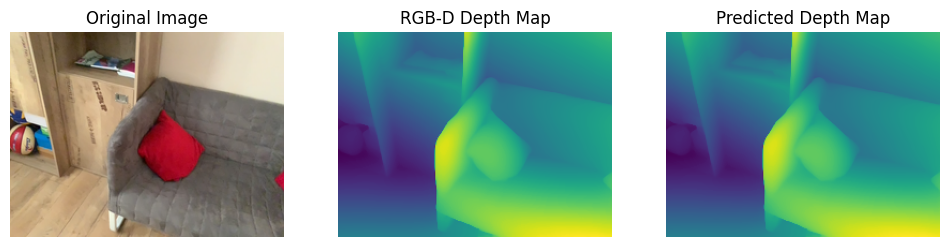

ARKit depth stats:
min=914.000, max=1709.000, mean=1300.559
DepthAnything depth stats:
min=29.000, max=254.000, mean=137.920


/tmp/ipykernel_972/4077039974.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  arkit_depth_array = imageio.imread(depth_map_path).astype(np.float32)


In [25]:
from transformers import pipeline
from PIL import Image
import requests
import numpy as np
import imageio

# Load pipeline
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
print(config.RGB_PATH)

image_name = "47333473_58549.751.png"

# Full path to the image
image_path = os.path.join(config.RGB_PATH, image_name)

# Load image
image = Image.open(image_path)

# Load RGB-D depth map for comparison
depth_map_path = os.path.join(config.DEPTH_PATH, image_name)
depth_map = Image.open(depth_map_path)

# Predict depth
depth_map = pipe(image)["depth"]

# Convert to NumPy and normalize for visualization
depth_array = np.array(depth_map).astype(np.float32)
depth_norm = (depth_array - depth_array.min()) / (depth_array.max() - depth_array.min())

# Show RGB + RGB-D + Estimated Depth side by side
plt.figure(figsize=(12, 6))

# Original RGB image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

# RGB-D depth map
plt.subplot(1, 3, 2)
plt.imshow(depth_map)#, cmap="plasma")
plt.axis("off")
plt.title("RGB-D Depth Map")

# Predicted depth map
plt.subplot(1, 3, 3)
plt.imshow(depth_array)#, cmap="plasma")
plt.axis("off")
plt.title("Predicted Depth Map")



plt.show()

arkit_depth_array = imageio.imread(depth_map_path).astype(np.float32)

print("ARKit depth stats:")
print(f"min={arkit_depth_array.min():.3f}, max={arkit_depth_array.max():.3f}, mean={arkit_depth_array.mean():.3f}")

print("DepthAnything depth stats:")
print(f"min={depth_array.min():.3f}, max={depth_array.max():.3f}, mean={depth_array.mean():.3f}")


The use of DepthAnything has already been included in the functions used for Part E, just run the algorithm with:

In [21]:
config.TRACKING_CONFIG["use_depth"] = False

In the following code, we are evaluating: Does DepthAnything produce consistent absolute depth values when the camera moves slightly or the scene changes a bit?

Processing frames:   0%|          | 0/10 [00:00<?, ?it/s]

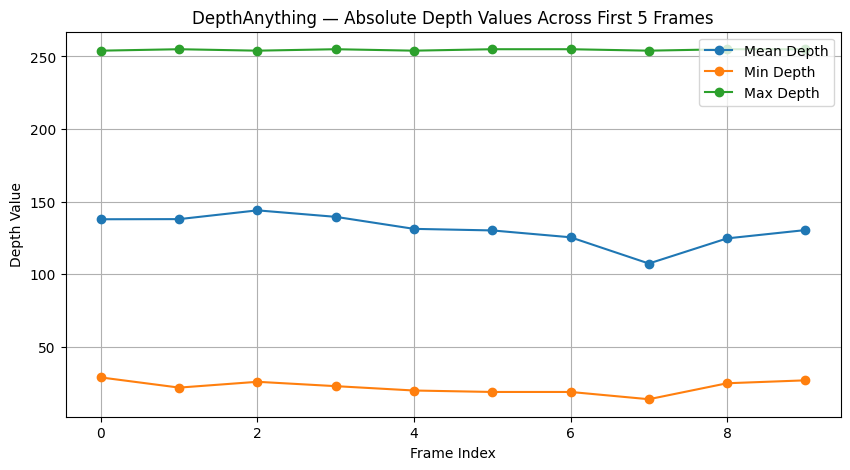

Average change in mean depth between frames: 7.307349
Max change in mean depth between frames: 18.064468


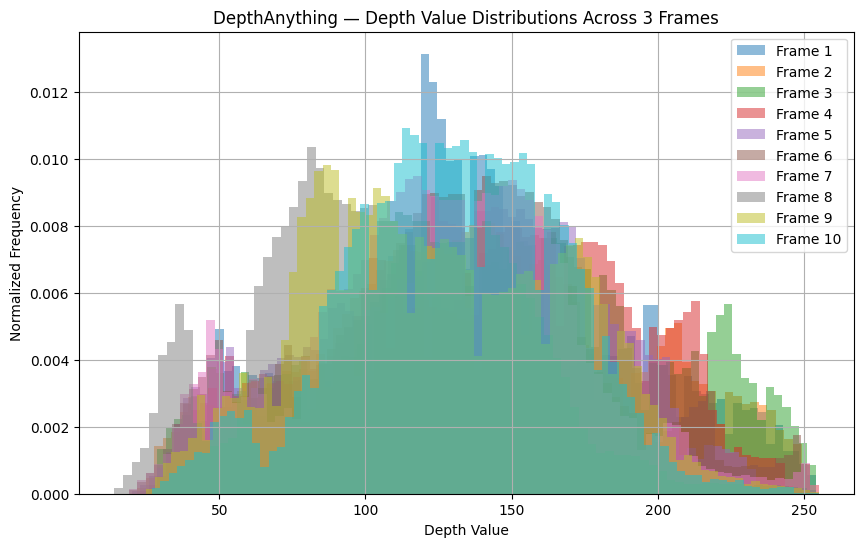

In [42]:
# Get frame metadata
start_frame = "47333473_58549.751.png"

frames_metadata = get_frame_list(config, frame_skip=1, max_frames=10, start_frame_name=start_frame)

depth_means = []
depth_mins = []
depth_maxs = []
depth_arrays = []

for frame_data in tqdm(frames_metadata, desc="Processing frames"):
    # Load images
    image = Image.open(frame_data['rgb_path']).convert("RGB")
    rgb_image = np.array(image)

    
    # Predict depth
    depth_map = pipe(image)["depth"]
    depth_array = np.array(depth_map).astype(np.float32)

    # Store stats
    depth_means.append(depth_array.mean())
    depth_mins.append(depth_array.min())
    depth_maxs.append(depth_array.max())
    depth_arrays.append(depth_array)


# Plot absolute depth evolution
plt.figure(figsize=(10, 5))
plt.plot(depth_means, marker='o', label="Mean Depth")
plt.plot(depth_mins, marker='o', label="Min Depth")
plt.plot(depth_maxs, marker='o', label="Max Depth")
plt.legend()
plt.title("DepthAnything — Absolute Depth Values Across First 5 Frames")
plt.xlabel("Frame Index")
plt.ylabel("Depth Value")
plt.grid(True)
plt.show()

# Quantify variability
depth_means = np.array(depth_means)
delta_means = np.abs(np.diff(depth_means))
print("Average change in mean depth between frames:", delta_means.mean())
print("Max change in mean depth between frames:", delta_means.max())


# Plot histograms of depth distributions
plt.figure(figsize=(10, 6))

for i, depth_array in enumerate(depth_arrays):
    plt.hist(
        depth_array.flatten(),
        bins=80,
        alpha=0.5,
        label = f"Frame {i+1}",
        density=True
    )

plt.title("DepthAnything — Depth Value Distributions Across 3 Frames")
plt.xlabel("Depth Value")
plt.ylabel("Normalized Frequency")
plt.legend()
plt.grid(True)
plt.show()

Processing frames:   0%|          | 0/10 [00:00<?, ?it/s]

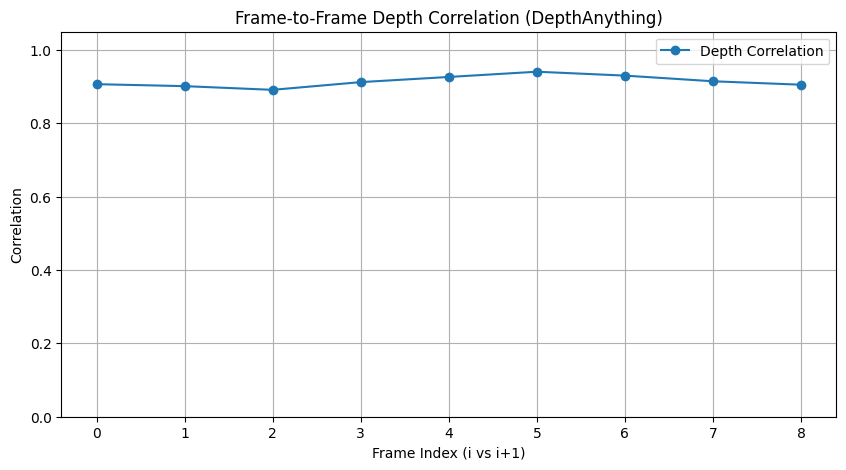

Average correlation: 0.915


In [43]:
depth_maps = []

for frame_data in tqdm(frames_metadata, desc="Processing frames"):
    # Load images
    image = Image.open(frame_data['rgb_path']).convert("RGB")
    rgb_image = np.array(image)

    
    # Predict depth
    depth_map = pipe(image)["depth"]
    depth_array = np.array(depth_map).astype(np.float32)
    depth_maps.append(depth_array)

# Compute correlations between consecutive frames
corrs = []

for i in range(len(depth_maps) - 1):
    d1 = depth_maps[i].flatten()
    d2 = depth_maps[i + 1].flatten()

    # Raw correlation
    corr = np.corrcoef(d1, d2)[0, 1]
    corrs.append(corr)


# Plot results
plt.figure(figsize=(10, 5))
plt.plot(corrs, marker='o', label="Depth Correlation")
plt.title("Frame-to-Frame Depth Correlation (DepthAnything)")
plt.xlabel("Frame Index (i vs i+1)")
plt.ylabel("Correlation")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()

# Print summary
print(f"Average correlation: {np.mean(corrs):.3f}")


## Comparison

We are now comparing the tracking with both depth methods. We will also use a dual slider to make the visualization easier.

In [48]:
def query_with_dual_slider(frame_results1, frame_results2, device=None, query=None):
    """Track objects in two frame sets with one interactive slider."""

    if not frame_results1 or not frame_results2:
        print("Error: One or both frame results lists are empty")
        return

    if device is None:
        _, _, device = load_sam_model(model_size='base')

    clip_model, clip_processor, _ = load_clip_model(device=device)

    # Initialize trackers
    tracker1 = ObjectTracker(config)
    tracker2 = ObjectTracker(config)

    # Target selection
    text_features_np = None
    if query is not None:
        text_inputs = clip_processor(text=[query], return_tensors="pt").to(device)
        with torch.no_grad():
            text_features = clip_model.get_text_features(**text_inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        text_features_np = text_features.cpu().numpy().squeeze()

    # Pick object to track (from first set)
    best_frame_id, best_object_id = 0, 0
    if query is None or text_features_np is None:
        best_area = 0
        for f_idx in range(min(3, len(frame_results1))):
            for o_idx, obj in enumerate(frame_results1[f_idx]['objects']):
                if obj['area_px'] > best_area:
                    best_area = obj['area_px']
                    best_frame_id, best_object_id = f_idx, o_idx
    else:
        best_score_overall = -1
        for f_idx, results in enumerate(frame_results1):
            for o_idx, obj in enumerate(results['objects']):
                if obj['clip_features'] is None:
                    continue
                sim = float(np.dot(obj['clip_features'], text_features_np))
                if sim > best_score_overall:
                    best_score_overall = sim
                    best_frame_id, best_object_id = f_idx, o_idx
        if best_score_overall < 0:
            print("No suitable object found for query.")
            return

    # Set initial target for both trackers
    target_features1 = frame_results1[best_frame_id]['objects'][best_object_id]['features']
    target_bbox1 = frame_results1[best_frame_id]['objects'][best_object_id]['bbox_3d']
    target_features2 = frame_results2[best_frame_id]['objects'][best_object_id]['features']
    target_bbox2 = frame_results2[best_frame_id]['objects'][best_object_id]['bbox_3d']
    tracker1.set_target(target_features1, target_bbox1)
    tracker2.set_target(target_features2, target_bbox2)

    # Process frames
    processed_frames1 = []
    processed_frames2 = []
    for idx, (results1, results2) in enumerate(zip(frame_results1, frame_results2)):
        # Frame 1
        frame1 = Image.open(results1['frame_data']['rgb_path']).convert("RGB")
        overlay1 = frame1.convert('RGBA')
        draw1 = ImageDraw.Draw(overlay1, 'RGBA')
        if results1['objects']:
            match = tracker1.find_best_match(results1['objects'])
            if match:
                obj = results1['objects'][match['index']]
                points_2d = project_points(results1['frame_data']['camera_intrinsics'], obj['bbox_3d'])
                if points_2d:
                    xs, ys = zip(*points_2d)
                    draw1.rectangle([min(xs), min(ys), max(xs), max(ys)], outline=(255,0,0,180), width=3)
                tracker1.update_target(obj['features'], obj['bbox_3d'], match['score'])
        processed_frames1.append(overlay1)

        # Frame 2
        frame2 = Image.open(results2['frame_data']['rgb_path']).convert("RGB")
        overlay2 = frame2.convert('RGBA')
        draw2 = ImageDraw.Draw(overlay2, 'RGBA')
        if results2['objects']:
            match = tracker2.find_best_match(results2['objects'])
            if match:
                obj = results2['objects'][match['index']]
                points_2d = project_points(results2['frame_data']['camera_intrinsics'], obj['bbox_3d'])
                if points_2d:
                    xs, ys = zip(*points_2d)
                    draw2.rectangle([min(xs), min(ys), max(xs), max(ys)], outline=(255,0,0,180), width=3)
                tracker2.update_target(obj['features'], obj['bbox_3d'], match['score'])
        processed_frames2.append(overlay2)

    # Slider
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=min(len(processed_frames1), len(processed_frames2))-1,
        step=1,
        description='Frame'
    )
    out1 = widgets.Output()
    out2 = widgets.Output()

    def show_frame(change):
        idx = change['new']
        with out1:
            clear_output(wait=True)
            display(processed_frames1[idx])
        with out2:
            clear_output(wait=True)
            display(processed_frames2[idx])

    slider.observe(show_frame, names='value')
    display(widgets.VBox([slider, out1, out2]))

    # Show first frames by default
    with out1:
        display(processed_frames1[0])
    with out2:
        display(processed_frames2[0])

    return tracker1, tracker2


In [34]:
# Extract objects from frames with depth from DepthAnything
config.TRACKING_CONFIG["use_depth"] = False
config.TRACKING_CONFIG['similarity_threshold'] = original_threshold

frame_results_da, device_id_da = analyse_frames(config, n_frames=20, start_frame="47333473_58548.751.png")


Loading SAM model (base)...
SAM model loaded on device: cuda
Loading DINOv2 model: facebook/dinov2-base...
DINOv2 model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...


/home/jovyan/EmbodiedAIProject/project/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIP model loaded on device: cuda


Processing frames:   0%|          | 0/20 [00:00<?, ?it/s]

Using DepthAnything for depth estimation.
Generating SAM proposals with 6x6 grid...
Generated 12 unique segment proposals
Using DepthAnything for depth estimation.
Generating SAM proposals with 6x6 grid...
Generated 9 unique segment proposals
Using DepthAnything for depth estimation.
Generating SAM proposals with 6x6 grid...
Generated 9 unique segment proposals
Using DepthAnything for depth estimation.
Generating SAM proposals with 6x6 grid...
Generated 11 unique segment proposals
Using DepthAnything for depth estimation.
Generating SAM proposals with 6x6 grid...
Generated 11 unique segment proposals
Using DepthAnything for depth estimation.
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Using DepthAnything for depth estimation.
Generating SAM proposals with 6x6 grid...
Generated 12 unique segment proposals
Using DepthAnything for depth estimation.
Generating SAM proposals with 6x6 grid...
Generated 14 unique segment proposals
Using DepthAnything for dep

In [35]:
print("=== Tracking with RGB-D ===")
tracker_moving = query_with_slider(frame_results, device=None, query="pillow")

print("=== Tracking with RGB + DepthAnything ===")
tracker_moving = query_with_slider(frame_results_da, device=None, query="pillow")

=== Tracking with RGB-D ===
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Starting tracking from frame 5, object 4
Tracking config: moving_target=False, threshold=0.6
Processing frames ...


=== Tracking with RGB + DepthAnything ===
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...
CLIP model loaded on device: cuda
Starting tracking from frame 5, object 4
Tracking config: moving_target=False, threshold=0.6
Processing frames ...


In [49]:
tracker_moving = query_with_dual_slider(frame_results, frame_results_da, device=None, query="pillow")

Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...


/home/jovyan/EmbodiedAIProject/project/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIP model loaded on device: cuda
